###**1. Data Collection and Preprocessing**

In [4]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import pandas as pd

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

df = pd.read_excel('/data_news.xlsx')
print(df.info())

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   category           50000 non-null  object
 1   headline           50000 non-null  object
 2   links              50000 non-null  object
 3   short_description  49995 non-null  object
 4   keywords           47294 non-null  object
dtypes: object(5)
memory usage: 1.9+ MB
None


In [5]:
dupicated_rows = df[df.duplicated()]
print("Number of duplicate rows: ", dupicated_rows.shape)
print(dupicated_rows.head())

Number of duplicate rows:  (4251, 5)
       category                                           headline  \
40027  BUSINESS          The 10 Cities With The Longest Work Weeks   
40089  BUSINESS         10 States Where People Drink The Most Beer   
40095  BUSINESS  Women in Business: Q&A with Venus Hurst, Found...   
40119  BUSINESS  Hiring Guru: Nationwide Debt Direct Hires for ...   
40134  BUSINESS  10 Things To Immediately Do If You Want Your S...   

                                                   links  \
40027  https://www.huffingtonpost.com/entry/cities-lo...   
40089  https://www.huffingtonpost.com/entry/states-be...   
40095  https://www.huffingtonpost.com/entry/women-in-...   
40119  https://www.huffingtonpost.com/entry/hiring-gu...   
40134  https://www.huffingtonpost.com/entry/10-things...   

                                       short_description  \
40027  Feeling overworked? Moving to a different city...   
40089  (Hat tip: UPI) We are a nation of beer drinker...   
4

In [6]:
df.drop_duplicates(inplace=True)
print(df.shape)

(45749, 5)


In [7]:
# Handle missing data
df["short_description"].fillna('',inplace=True)
df["keywords"].fillna('',inplace=True)

# Combine headline and short description
df['text'] = df['headline'] + ' ' + df['short_description']

def clean_text(text):
  text = text.lower()  # Convert to lowercase
  text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove non-alphabetic characters
  text = re.sub(r'http\S+|www.\S+', '', text)  # Remove URLs
  text = word_tokenize(text)  # Tokenize text
  text = [word for word in text if word not in stopwords.words('english') and word not in string.punctuation]  # Remove stopwords and punctuations
  lemmatizer = WordNetLemmatizer()
  text = [lemmatizer.lemmatize(word) for word in text]  # Lemmatize words
  text = ' '.join(text)
  return text

df['cleaned_text'] = df['text'].apply(clean_text)
display(df['cleaned_text'])


<ipython-input-7-8853f9795775>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["short_description"].fillna('',inplace=True)
<ipython-input-7-8853f9795775>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using '

,cleaned_text
0,143 mile 35 day lesson learned resting part tr...
1,talking crazy crazy helpful think talking tool...
2,crenezumab trial gauge whether alzheimers drug...
3,oh difference made want busy keep trying perfe...
4,green superfoods first bad news soda bread cor...
...,...
49988,gregg popovich wish gut dye hair blond monday ...
49991,rafal lipinski nail sick complicated dunk plen...
49995,baseball team learned there wrong way celebrat...
49996,young spur fan dabbed 38 time single playoff g...


In [8]:
final_dataset = df[['category', 'cleaned_text']]
final_dataset.to_excel('final_data_news.xlsx', index=False)

###**2. Feature Extraction**

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
from gensim.models import Word2Vec
from collections import Counter
from wordcloud import WordCloud

df = pd.read_excel('/content/final_data_news.xlsx')

In [ ]:
# Display basic information about the data
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45749 entries, 0 to 45748
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   category      45749 non-null  object
 1   cleaned_text  45749 non-null  object
dtypes: object(2)
memory usage: 715.0+ KB
None
   category                                       cleaned_text
0  WELLNESS  143 mile 35 day lesson learned resting part tr...
1  WELLNESS  talking crazy crazy helpful think talking tool...
2  WELLNESS  crenezumab trial gauge whether alzheimers drug...
3  WELLNESS  oh difference made want busy keep trying perfe...
4  WELLNESS  green superfoods first bad news soda bread cor...


In [ ]:
# Convert text data into numerical features using Bag-of-Words
bow_vectorizer = CountVectorizer()
bow_features = bow_vectorizer.fit_transform(df['cleaned_text'])
print("Bag-of-Words Matrix Shape:",bow_features.shape)

Bag-of-Words Matrix Shape: (45749, 52742)


In [10]:
# Convert text data into numerical features using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_features = tfidf_vectorizer.fit_transform(df['cleaned_text'])
print("TF-IDF Matrix Shape:",tfidf_features.shape)


TF-IDF Matrix Shape: (45749, 52740)


<ipython-input-17-5c0fd61feb7c>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


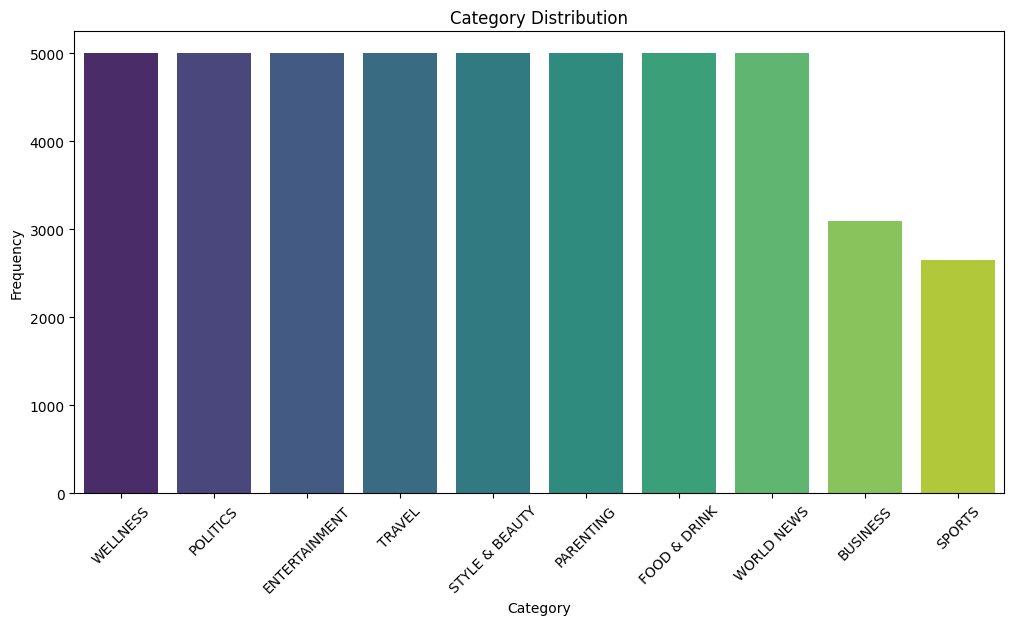

In [ ]:
# Category Distribution
category_counts = df['category'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.title('Category Distribution')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Tokenizing text data for Word2Vec
tokenized_texts = df['cleaned_text'].apply(word_tokenize)

#Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=2, workers=4)
sample_word = input("Enter a word to find similar words: ")
if sample_word in word2vec_model.wv:
    print(f"Words similar to '{sample_word}':", word2vec_model.wv.most_similar(sample_word))
else:
    print(f"'{sample_word}' not found in Word2Vec vocabulary.")

Enter a word to find similar words: happy
Words similar to 'happy': [('vacation', 0.9559623599052429), ('fun', 0.9534903764724731), ('stay', 0.9524244070053101), ('perfect', 0.9486242532730103), ('splurge', 0.9468443393707275), ('dad', 0.9437440633773804), ('breakfast', 0.9433764219284058), ('meal', 0.9430361390113831), ('enjoy', 0.9408403038978577), ('here', 0.9367291331291199)]


In [ ]:
# Word Frequency Analysis
all_words = [word for tokens in tokenized_texts for word in tokens]
word_freq = Counter(all_words)
print("Top 10 Most Common Words:", word_freq.most_common(10))

Top 10 Most Common Words: [('photo', 5078), ('new', 4772), ('one', 4307), ('u', 3828), ('year', 3549), ('day', 3527), ('time', 3517), ('like', 2966), ('make', 2941), ('get', 2721)]


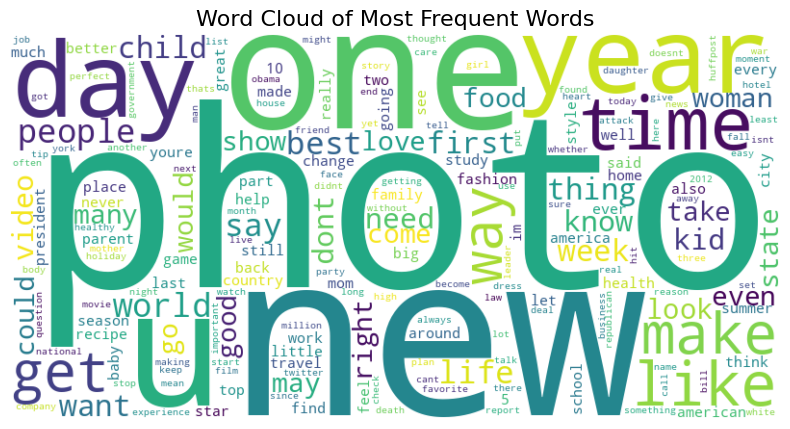

In [ ]:
# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Words', fontsize=16)
plt.show()

###**3. Model Development and Training**

In [11]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

X = tfidf_features
y = df['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
print("Logistic Regression:")
print(classification_report(y_test, y_pred_log_reg))

Logistic Regression:
                precision    recall  f1-score   support

      BUSINESS       0.76      0.61      0.68       631
 ENTERTAINMENT       0.76      0.83      0.79       990
  FOOD & DRINK       0.86      0.88      0.87       994
     PARENTING       0.79      0.80      0.79       973
      POLITICS       0.77      0.76      0.76      1001
        SPORTS       0.86      0.73      0.79       533
STYLE & BEAUTY       0.86      0.83      0.85      1027
        TRAVEL       0.81      0.81      0.81       983
      WELLNESS       0.73      0.79      0.76      1024
    WORLD NEWS       0.78      0.83      0.80       994

      accuracy                           0.80      9150
     macro avg       0.80      0.79      0.79      9150
  weighted avg       0.80      0.80      0.80      9150



In [ ]:
# Cross-validation for Logistic Regression
log_ref_cv_scores = cross_val_score(log_reg,X, y, cv=5, scoring='accuracy')
print("Logistic Regression Cross-Validation Scores:", log_ref_cv_scores)
print("Mean Accuracy:", log_ref_cv_scores.mean())

Logistic Regression Cross-Validation Scores: [0.79846995 0.79704918 0.79661202 0.79857923 0.80281998]
Mean Accuracy: 0.798706072567876


In [15]:
#Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print("Naive Bayes:")
print(classification_report(y_test, y_pred_nb))

Naive Bayes:
                precision    recall  f1-score   support

      BUSINESS       0.94      0.29      0.44       631
 ENTERTAINMENT       0.78      0.76      0.77       990
  FOOD & DRINK       0.86      0.87      0.86       994
     PARENTING       0.62      0.82      0.71       973
      POLITICS       0.70      0.80      0.75      1001
        SPORTS       0.95      0.40      0.56       533
STYLE & BEAUTY       0.85      0.84      0.85      1027
        TRAVEL       0.77      0.83      0.79       983
      WELLNESS       0.67      0.78      0.72      1024
    WORLD NEWS       0.77      0.85      0.81       994

      accuracy                           0.76      9150
     macro avg       0.79      0.72      0.73      9150
  weighted avg       0.78      0.76      0.75      9150



In [ ]:
# Cross-validation for Naive Bayes
nb_cv_scores = cross_val_score(nb, X, y, cv=5, scoring='accuracy')
print("Naive Bayes Cross-Validation Scores:", nb_cv_scores)
print("Mean Accuracy:", nb_cv_scores.mean())

Naive Bayes Cross-Validation Scores: [0.75934426 0.76262295 0.75650273 0.76251366 0.76675046]
Mean Accuracy: 0.761546814217804


In [12]:
# Support Vector Machine (SVM)
svm = SVC(kernel = 'linear', C =1, random_state = 42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("Support Vector Machine (SVM):")
print(classification_report(y_test, y_pred_svm))

Support Vector Machine (SVM):
                precision    recall  f1-score   support

      BUSINESS       0.72      0.67      0.69       631
 ENTERTAINMENT       0.76      0.84      0.80       990
  FOOD & DRINK       0.86      0.88      0.87       994
     PARENTING       0.78      0.80      0.79       973
      POLITICS       0.80      0.75      0.77      1001
        SPORTS       0.85      0.75      0.80       533
STYLE & BEAUTY       0.89      0.85      0.87      1027
        TRAVEL       0.82      0.81      0.82       983
      WELLNESS       0.76      0.78      0.77      1024
    WORLD NEWS       0.79      0.82      0.81       994

      accuracy                           0.80      9150
     macro avg       0.80      0.80      0.80      9150
  weighted avg       0.80      0.80      0.80      9150



In [ ]:
# Cross-validation for SVM
svm_cv_scores = cross_val_score(svm, X, y, cv=5, scoring='accuracy')
print("SVM Cross-Validation Scores:", svm_cv_scores)
print("Mean Accuracy:", svm_cv_scores.mean())


SVM Cross-Validation Scores: [0.79759563 0.7968306  0.7979235  0.7989071  0.79965023]
Mean Accuracy: 0.7981814131198907


###**4. Model Evaluation**

In [16]:
def evaluate_model(model):
  y_pred_dict = {'log_reg': y_pred_log_reg, 'nb': y_pred_nb, 'svm': y_pred_svm}
  accuracy = accuracy_score(y_test, y_pred_dict[model])
  precision = precision_score(y_test, y_pred_dict[model], average='weighted')
  recall = recall_score(y_test, y_pred_dict[model], average='weighted')
  f1 = f1_score(y_test, y_pred_dict[model], average='weighted')
  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1-Score: {f1:.4f}")
  return accuracy, precision, recall, f1

print("Logistic Regression:")
log_reg_accuracy, log_reg_precision, log_reg_recall, log_reg_f1 = evaluate_model('log_reg')

print("\nNaive Bayes:")
nb_accuracy, nb_precision, nb_recall, nb_f1 = evaluate_model('nb')

print("\nSupport Vector Machine (SVM):")
svm_accuracy, svm_precision, svm_recall, svm_f1 = evaluate_model('svm')



Logistic Regression:
Accuracy: 0.7967
Precision: 0.7980
Recall: 0.7967
F1-Score: 0.7960

Naive Bayes:
Accuracy: 0.7564
Precision: 0.7783
Recall: 0.7564
F1-Score: 0.7462

Support Vector Machine (SVM):
Accuracy: 0.8033
Precision: 0.8042
Recall: 0.8033
F1-Score: 0.8031


In [17]:
# Select the best model
best_model = max([(log_reg_accuracy, log_reg), (nb_accuracy, nb), (svm_accuracy, svm)], key=lambda x: x[0])
print(f"The best model is {best_model[1]} with an accuracy of {best_model[0]}.")

The best model is SVC(C=1, kernel='linear', random_state=42) with an accuracy of 0.8032786885245902.


In [18]:
# Function to predict the category of a new article
def predict_category(user_input):
  cleaned_input = clean_text(user_input)
  input_features = tfidf_vectorizer.transform([cleaned_input]) # Vectorize the input
  prediction = best_model[1].predict(input_features)[0] # Predict the category
  return prediction

# Get user input
user_input = input("Enter a news article: ")

# Predict and print the category
predicted_category = predict_category(user_input)
print("Predicted category:", predicted_category)

Enter a news article: My husband beaten to death for asking to lower volume for our kids to sleep
Predicted category: PARENTING


###**5. Final Report and Presentation**

The primary objective was to preprocess the data, build classification models, evaluate their performance, and determine the best model for classification and this report provide the details of the same.

Step-1:
Initially, the original dataset was loaded and all the necessary libraries were loaded for preprocessing. Vaious preprocessing methods were implemented like removing duplicate rows, handling missing values, combining 2 text columns and cleaning the data by lowering text case, removing unwanted characters, tokenizing and lemmetizing the data.

The new excel file was created containing only the category column and the cleaned textual data.

Step-2:
Using the cleaned dataset, feature extraction process began using methods like TF-IDF, Word2Vec and
bag-of-words to convert these features from text format into numerical format.

Step-3:
Three classification algorithms were implemented:
Logistic Regression, Naive Bayes and Support Vector Machines (SVM) along with its cross validation and found that Logistic Regression and SVM shows similar level of accuracy scores.

Step-4: Models were evaluated using:
Accuracy, Precision, Recall, F1-Score and it was found that The Support Vector Machine (SVM) achieved the highest accuracy (0.80) and was selected as the best-performing model.